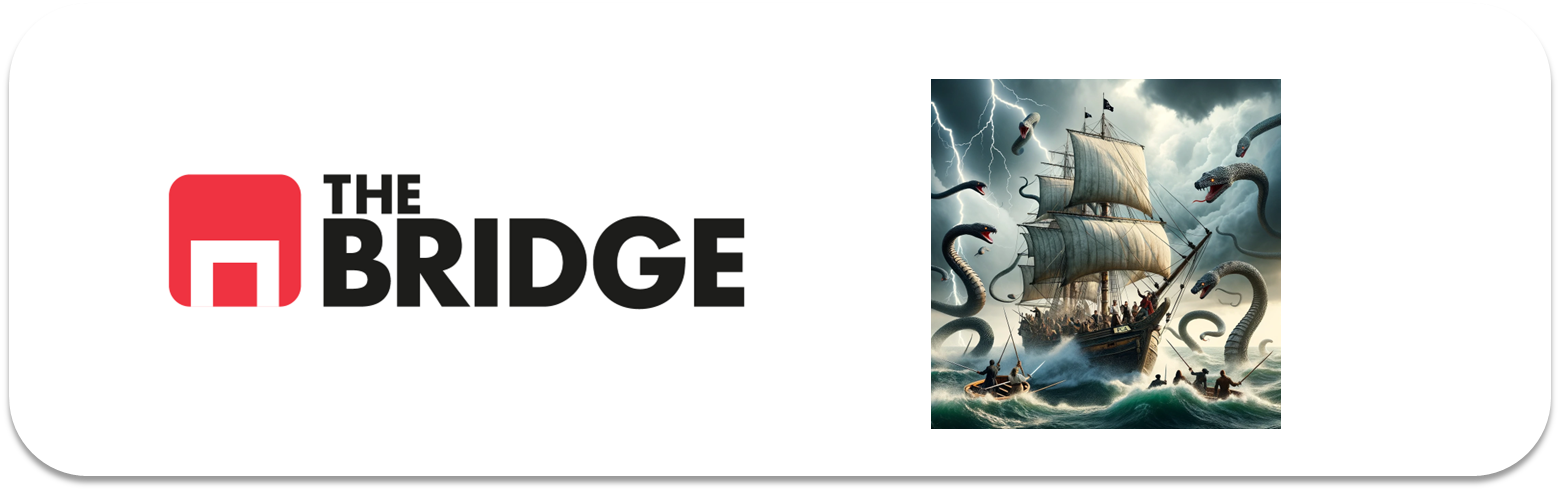

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from collections import Counter

from pandas.api.types import is_numeric_dtype

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


_________________

### 1. Cargo los datos, limpio y transformo las variables

In [2]:
df = pd.read_csv('./data/credit_npo.csv')
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [3]:
# Elimino las filas con nulos

df.dropna(axis=0, inplace=True)

In [4]:
# Separo en Train y Test

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [80]:
# Transformo las variables que empiezan por "NumberOf" en categóricas
# Primero veo los valores unicos de cada variable

for col in train.columns[train.columns.str.startswith('NumberOf')]:
    print(f'Valores únicos en {col}')
    print(train[col].unique())

Valores únicos en NumberOfTime30-59DaysPastDueNotWorse
[ 0  1  3  2  4  6  5 98  8  7]
Valores únicos en NumberOfOpenCreditLinesAndLoans
[13  7  3  9  5 10 24 15 11  4  8 12  1 25  2  6 14 35 18 16  0 19 20 17
 22 23 21 27 29 34 28 48 26 30 31 32 33 40 41 49 36]
Valores únicos en NumberOfTimes90DaysLate
[ 0  2  1  5  4  3 98  7  9  6 10]
Valores únicos en NumberOfTime60-89DaysPastDueNotWorse
[ 0  4  1  2 98  3  5 11]
Valores únicos en NumberOfDependents
[ 0.  1.  3.  2.  5.  4.  6.  7.  8. 10.]


In [5]:
# Convierto en 3 niveles
# Para NumberOfTime30-59DaysPastDueNotWorse --> Pagos atrasados entre 30 a 59 dias
train['NumberOfTime30-59DaysPastDueNotWorse_cat'] = pd.cut(train['NumberOfTime30-59DaysPastDueNotWorse'],
                                                           bins=[-1,0,4,float('inf')], # Limites para categorizar la variable (-1,0 --> No retrasos, 1-4 --> Retrasos moderados, <4 --> Retrasos severos)
                                                           labels=['No retrasos', 'Retrasos moderados', 'Retrasos severos'])
test['NumberOfTime30-59DaysPastDueNotWorse_cat'] = pd.cut(test['NumberOfTime30-59DaysPastDueNotWorse'],
                                                           bins=[-1,0,4,float('inf')],
                                                           labels=['No retrasos', 'Retrasos moderados', 'Retrasos severos'])

In [6]:
# Para NumberOfOpenCreditLinesAndLoans --> Numero total de lineas de credito y prestamos abiertos
train['NumberOfOpenCreditLinesAndLoans_cat'] = pd.cut(train['NumberOfOpenCreditLinesAndLoans'], 
                                                   bins=[-1, 10, 20, float('inf')], 
                                                   labels=['Pocas líneas', 'Moderadas', 'Muchas líneas'])
test['NumberOfOpenCreditLinesAndLoans_cat'] = pd.cut(test['NumberOfOpenCreditLinesAndLoans'], 
                                                   bins=[-1, 10, 20, float('inf')], 
                                                   labels=['Pocas líneas', 'Moderadas', 'Muchas líneas'])

In [7]:
# Para NumberOfTimes90DaysLate --> Cuantas veces la persona ha tenido pagos atrasados 90 dias o mas
train['NumberOfTimes90DaysLate_cat'] = pd.cut(train['NumberOfTimes90DaysLate'], 
                                           bins=[-1, 0, 4, float('inf')], 
                                           labels=['No retrasos', 'Retrasos moderados', 'Retrasos severos'])
test['NumberOfTimes90DaysLate_cat'] = pd.cut(test['NumberOfTimes90DaysLate'], 
                                           bins=[-1, 0, 4, float('inf')], 
                                           labels=['No retrasos', 'Retrasos moderados', 'Retrasos severos'])

In [8]:
# Para NumberOfTime60-89DaysPastDueNotWorse --> numero de veces que la persona ha tenido pagos atrasados entre 60 y 89 dias
train['NumberOfTime60-89DaysPastDueNotWorse_cat'] = pd.cut(train['NumberOfTime60-89DaysPastDueNotWorse'], 
                                                        bins=[-1, 0, 4, float('inf')], 
                                                        labels=['No retrasos', 'Retrasos moderados', 'Retrasos severos'])
test['NumberOfTime60-89DaysPastDueNotWorse_cat'] = pd.cut(test['NumberOfTime60-89DaysPastDueNotWorse'], 
                                                        bins=[-1, 0, 4, float('inf')], 
                                                        labels=['No retrasos', 'Retrasos moderados', 'Retrasos severos'])

In [9]:
# Para NumberOfDependents --> numero de dependientes financieros
train['NumberOfDependents_cat'] = pd.cut(train['NumberOfDependents'], 
                                      bins=[-1, 0, 3, float('inf')], 
                                      labels=['Ninguno', 'Pocos dependientes', 'Muchos dependientes'])
test['NumberOfDependents_cat'] = pd.cut(test['NumberOfDependents'], 
                                      bins=[-1, 0, 3, float('inf')], 
                                      labels=['Ninguno', 'Pocos dependientes', 'Muchos dependientes'])

### 2. MiniEda

#### 2.1. Análisis Visual con correlación y umbral de covarianza

In [10]:
# Creo las variables para la Target y las columnas numericas y categoricas
target = 'SeriousDlqin2yrs'
var_num = [col for col in train.columns if is_numeric_dtype(train[col]) and col != target and not col.startswith('NumberOf')]
var_cat = [col for col in train.columns if not is_numeric_dtype(train[col])]

In [87]:
# Visualizo la target
train[target].unique()

array([0, 1], dtype=int64)

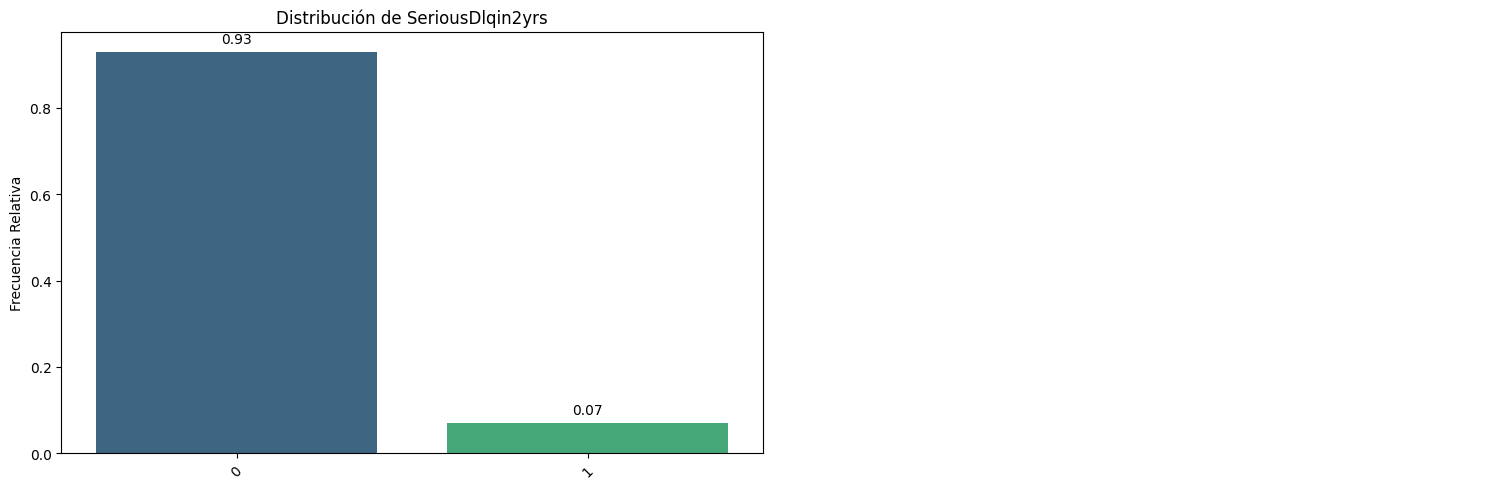

In [88]:
bt.pinta_distribucion_categoricas(train, [target], relativa=True, mostrar_valores=True)

Muchísimo desvalanceo, lo tendré en cuenta a la hora de elegir la métrica

**ANÁLISIS VISUAL ENTRE TARGET (CATEGÓRICA BINARIA) Y LAS VARIABLES CATEGÓRICAS**

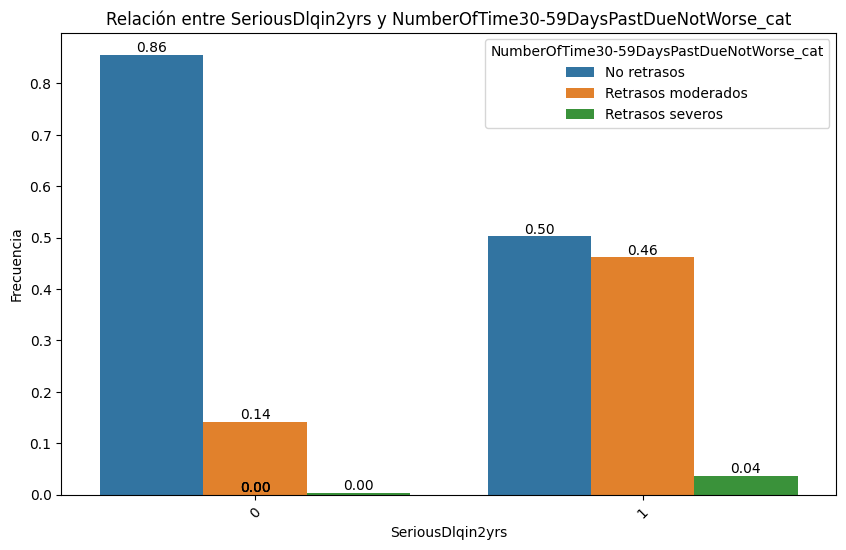

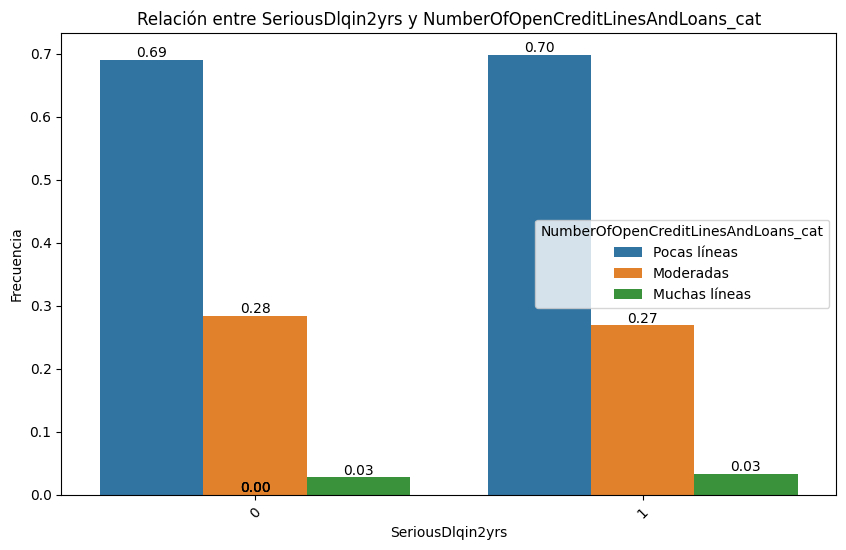

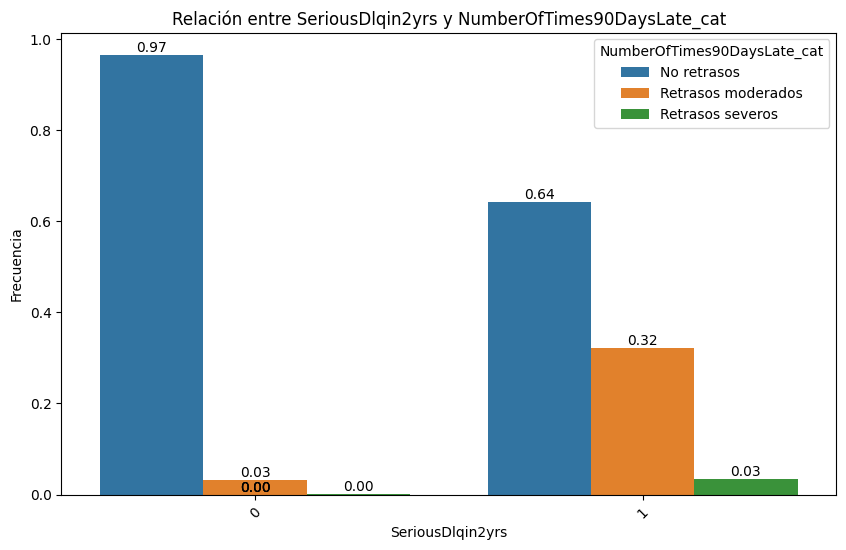

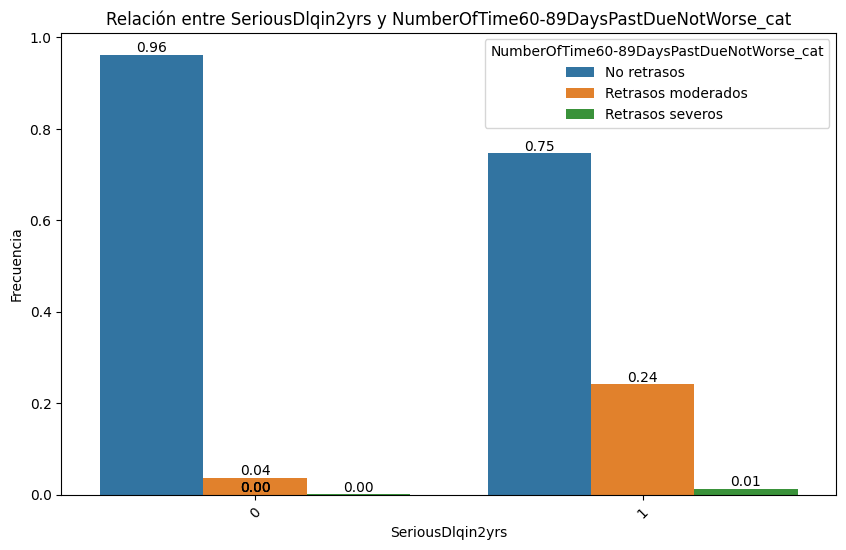

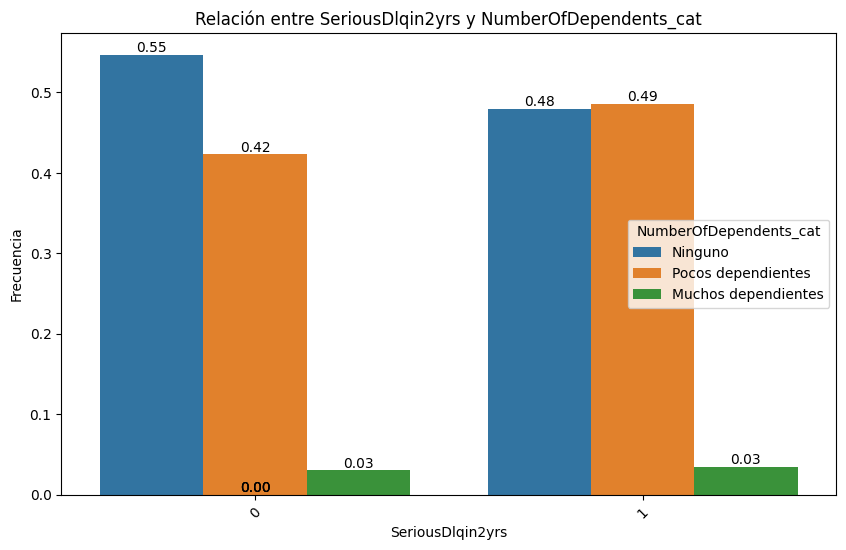

In [89]:
for col in var_cat:
    bt.plot_categorical_relationship_fin(train, target, col, show_values=True, relative_freq=True)

- Relación de `SeriousDlqin2yrs` con `NumberOfTime30-59DaysPastDueNotWorse_cat` tiene una diferencia clara. 
    - El 86% de las personas que no tienen ningun retraso entre 30 y 59 días no suelen tener un impago grave frente al 50% que sí lo tienen.
    - El 14% de las perinas que tienen retrasos moderados no tienen impagos graves y el 46% sí los tiene. **Diferencia**

- Relación de `SeriousDlqin2yrs` y `NumberOfOpenCreditLinesAndLoans_cat`:
    - La distribución es muy parecida.

- Relación con `NumberOfTimes90DaysLate_cat`:
    - Hay una diferencia en las personas con retrasos moderados que con un 3% no tienen impagos graves frente a un 32% que sí lo tienene

- Relación con `NumberOfTime60-89DaysPastDueNotWorse_cat`:
    - Hay diferencia igual que la anteior.

- Relación con `NumberOfDependents_cat`:
    - Hay una pequeña diferencia en las personas que tienen pocos dependientes ya que supera en un 1% en impagos graves con las personas que no tienen personas dependientes

In [11]:
features_visual = ['NumberOfTime30-59DaysPastDueNotWorse_cat', 'NumberOfTimes90DaysLate_cat', 'NumberOfTime60-89DaysPastDueNotWorse_cat']

**ANÁLISIS VISUAL CON LAS VARIABLES NUMÉRICAS**

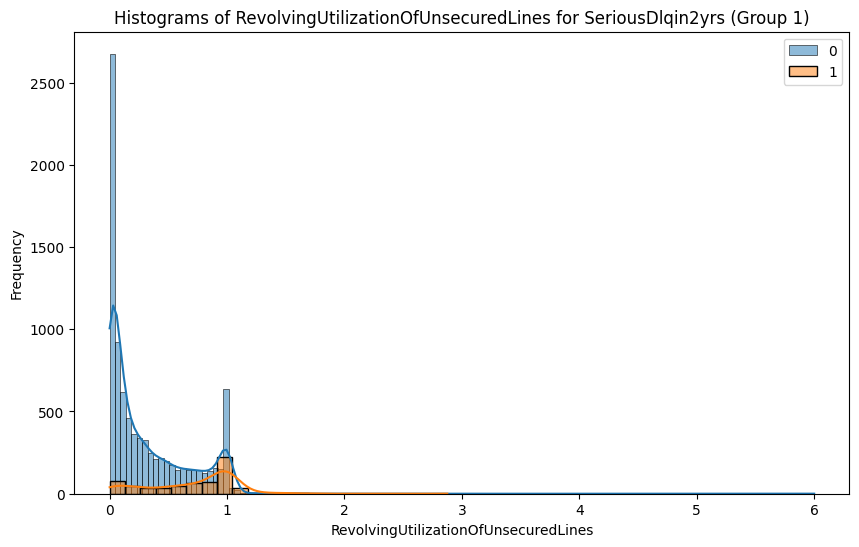

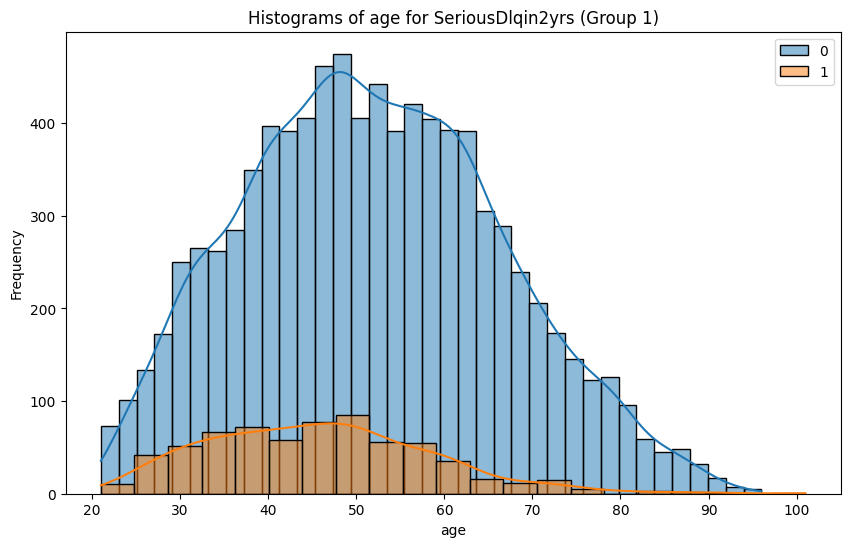

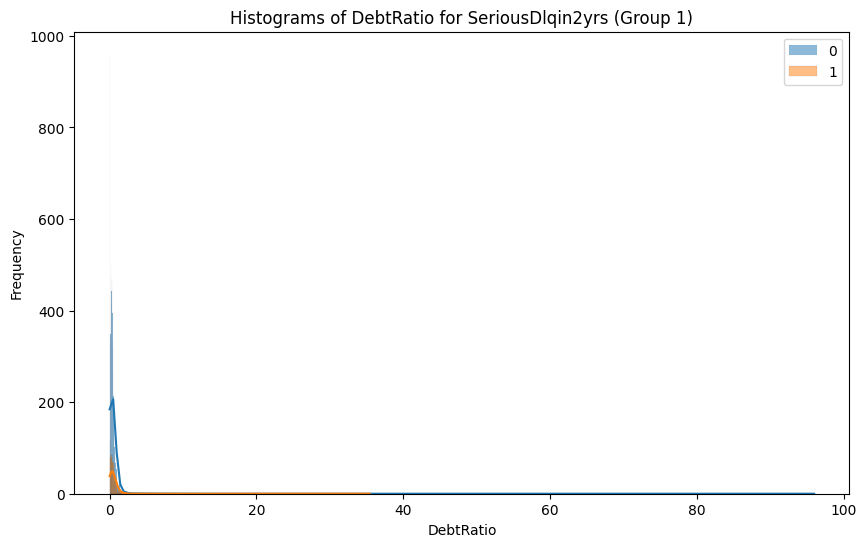

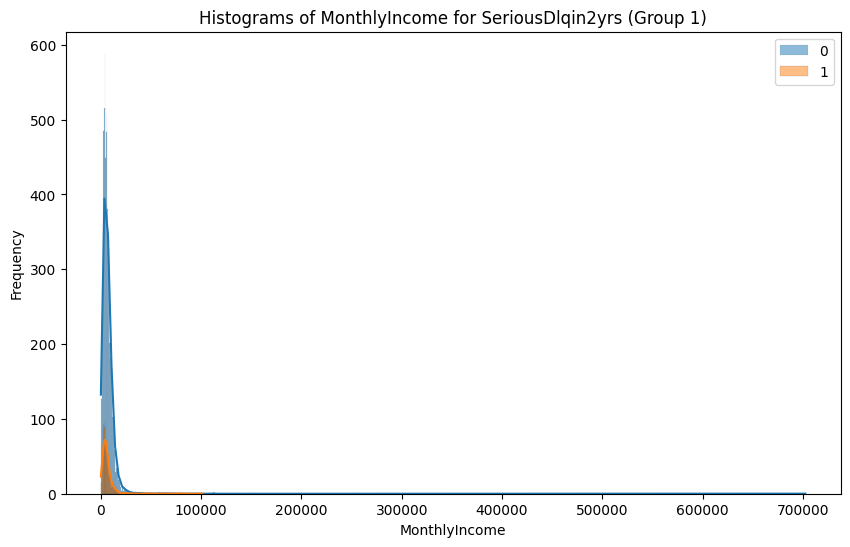

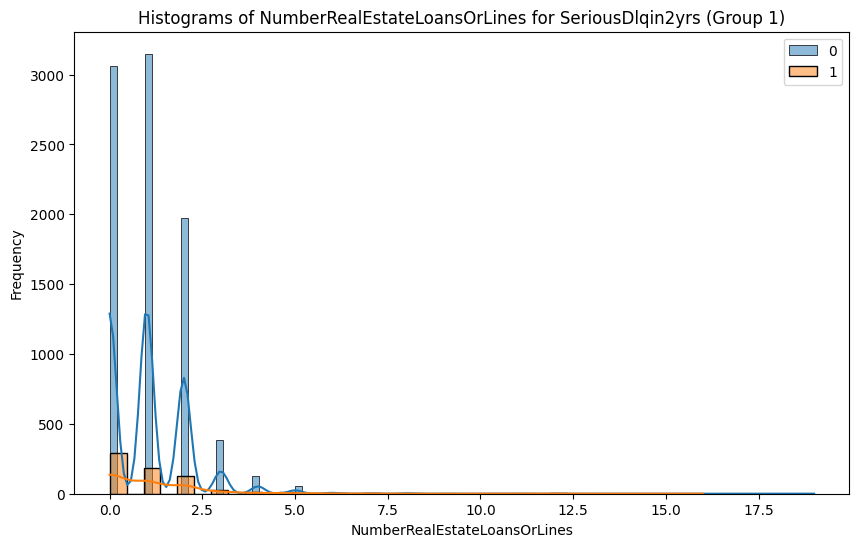

In [91]:
for col in var_num:
    bt.plot_grouped_histograms(train, cat_col=target, num_col=col, group_size=2)

No veo claras las diferencias en las gráficas de las variables numéricas y la target por lo que voy a realizar una análisis de la **correlación** y el **umbral de covarianza**

In [92]:

var_num.append(target)
corr = train[var_num].corr()
series_corr = np.abs(corr[target])
series_corr_sorted = series_corr.sort_values(ascending=False)
print(series_corr_sorted)

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines    0.284084
age                                     0.107801
MonthlyIncome                           0.018163
DebtRatio                               0.001863
NumberRealEstateLoansOrLines            0.001677
Name: SeriousDlqin2yrs, dtype: float64


In [93]:
# Pongo un umbral de covarianza bajo ya que las correlaciones no son muy altas
r_minimo = 0.01
val_num_sel = series_corr[series_corr >= r_minimo].index.to_list()
val_num_sel

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'MonthlyIncome',
 'SeriousDlqin2yrs']

In [94]:
for var in val_num_sel:
    features_visual.append(var)

<Axes: >

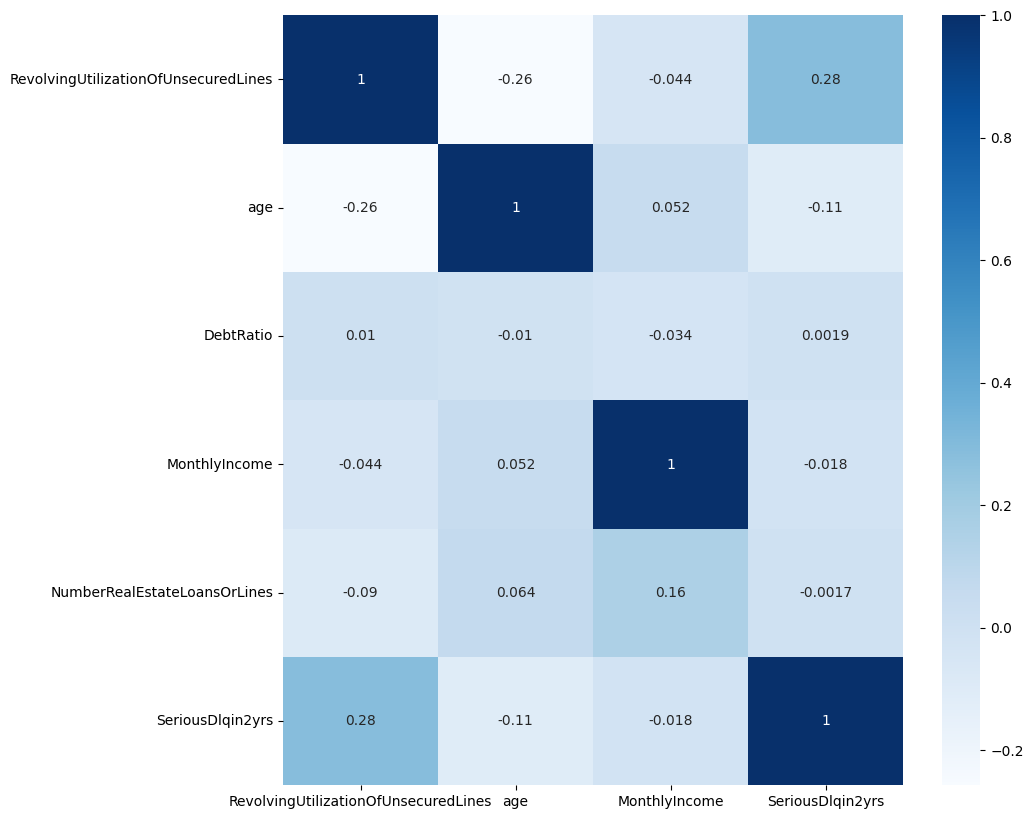

In [95]:
plt.figure(figsize=(10,10))
sns.heatmap(corr[val_num_sel], annot=True, cmap='Blues')

Viendo el análisis visual, con las correlaciones y este mapa de calor, se ve que no tienen muchísima relación con la target

#### 2.2. Análisis con **SelectKBest**, **ANOVA** y **Mutual Information**

In [96]:
# Variables numericas con SelectKBest y ANOVA
var_num.remove(target)

In [12]:
selector = SelectKBest(f_classif, k=3)
X_data_kbest = selector.fit_transform(train[var_num], train[target])
X_train_kbest = pd.DataFrame(X_data_kbest, columns=selector.get_feature_names_out())
features_kbest = selector.get_feature_names_out().tolist()
features_kbest

['RevolvingUtilizationOfUnsecuredLines', 'age', 'MonthlyIncome']

In [14]:
# Variables categoricas con Mutual Information
score_mi = []
for col in var_cat:
    score = mutual_info_score(train[col], train[target])
    score_mi.append(score)
    print(f'MI({col};{target}):', score)

MI(NumberOfTime30-59DaysPastDueNotWorse_cat;SeriousDlqin2yrs): 0.023186096048242538
MI(NumberOfOpenCreditLinesAndLoans_cat;SeriousDlqin2yrs): 7.100900319180307e-05
MI(NumberOfTimes90DaysLate_cat;SeriousDlqin2yrs): 0.034848165664494224
MI(NumberOfTime60-89DaysPastDueNotWorse_cat;SeriousDlqin2yrs): 0.017999922405432384
MI(NumberOfDependents_cat;SeriousDlqin2yrs): 0.0005926020022183377


Sale unos valores muy bajitos por lo que seleccionaré tres que puede tener algo de relevancia con la target, los que superen el 0.1 de score

In [15]:
features_mi = []
for col,score in zip(var_cat, score_mi):
    if score > 0.01:
        features_mi.append(col)
features_mi

['NumberOfTime30-59DaysPastDueNotWorse_cat',
 'NumberOfTimes90DaysLate_cat',
 'NumberOfTime60-89DaysPastDueNotWorse_cat']

#### 2.3. Análisis con **SelectFromModel**

In [16]:
# Instancio el modelo que voy a emplear como selector:
rf_selector = RandomForestClassifier(random_state=42)

In [17]:
# Veo primero con RF
rf_selector.fit(train[var_num], train[target])

RandomForestClassifier(random_state=42)

In [102]:
rf_selector.feature_importances_

array([0.30729945, 0.16163706, 0.24718056, 0.23626421, 0.04761871])

In [103]:
# Filtro por la media
rf_selector.feature_importances_[rf_selector.feature_importances_ > rf_selector.feature_importances_.mean()]

array([0.30729945, 0.24718056, 0.23626421])

In [18]:
# Uso SelectFromModel
selector_model_rf = SelectFromModel(estimator = rf_selector, threshold= "median")

In [19]:
selector_model_rf.fit(train[var_num], train[target])

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')

In [20]:
features_model_rf = selector_model_rf.get_feature_names_out().tolist()
features_model_rf

['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']

#### 2.4. Análisis con **RFE**

In [21]:
# Instancio el modelo con el que voy a usar RFE
rf_RFE = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf_RFE,
          n_features_to_select=3,
          step=1)

rfe.fit(train[var_num], train[target])
features_rfe = rfe.get_feature_names_out().tolist()
features_rfe

['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']

#### 2.5. Análisis con **SFS**

In [22]:
# Instancio el modelo con el que voy a usar SFS
rf_SFS = RandomForestClassifier(random_state=42)
sfs = SequentialFeatureSelector(rf_SFS,
                                n_features_to_select=3,
                                cv=3,
                                scoring='balanced_accuracy')
sfs.fit(train[var_num], train[target])
features_sfs = sfs.get_feature_names_out().tolist()
features_sfs

['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']

#### 2.6. Hard-voting con las features selecciondas anteriores

In [23]:
resultados = [features_visual, features_kbest, features_model_rf, features_rfe, features_sfs, features_mi]

In [24]:
# Cuento las veces que se repite una feature en cada selección de los analisis
contador = Counter()
for análisis in resultados:
    contador.update(análisis)
contador


Counter({'RevolvingUtilizationOfUnsecuredLines': 4,
         'MonthlyIncome': 4,
         'DebtRatio': 3,
         'NumberOfTime30-59DaysPastDueNotWorse_cat': 2,
         'NumberOfTimes90DaysLate_cat': 2,
         'NumberOfTime60-89DaysPastDueNotWorse_cat': 2,
         'age': 1})

In [25]:
umbral = 3  # Selecciono las features que hayan recibido al menos 3 votos
features_hard = [feature for feature, votes in contador.items() if votes >= umbral]
features_hard

['RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'DebtRatio']

In [26]:
# Añado la lista de features a la lista de resultados para iterar despues
resultados.append(features_hard)
resultados

[['NumberOfTime30-59DaysPastDueNotWorse_cat',
  'NumberOfTimes90DaysLate_cat',
  'NumberOfTime60-89DaysPastDueNotWorse_cat'],
 ['RevolvingUtilizationOfUnsecuredLines', 'age', 'MonthlyIncome'],
 ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'],
 ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'],
 ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'],
 ['NumberOfTime30-59DaysPastDueNotWorse_cat',
  'NumberOfTimes90DaysLate_cat',
  'NumberOfTime60-89DaysPastDueNotWorse_cat'],
 ['RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'DebtRatio']]

In [27]:
#Elimino las categoricas, de momento
resultados.pop(0)

['NumberOfTime30-59DaysPastDueNotWorse_cat',
 'NumberOfTimes90DaysLate_cat',
 'NumberOfTime60-89DaysPastDueNotWorse_cat']

In [28]:
resultados.pop(4)

['NumberOfTime30-59DaysPastDueNotWorse_cat',
 'NumberOfTimes90DaysLate_cat',
 'NumberOfTime60-89DaysPastDueNotWorse_cat']

In [29]:
resultados

[['RevolvingUtilizationOfUnsecuredLines', 'age', 'MonthlyIncome'],
 ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'],
 ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'],
 ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'],
 ['RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome', 'DebtRatio']]

### 3. Entrenamiento

In [47]:
base_score = {}
cv = {}
nombre_resultados = ['features_kbest', 'features_model_rf', 'features_rfe', 'features_sfs', 'features_hard']
for analisis,name in zip(resultados, nombre_resultados):
    # Creo X,y para cada seleccion de features
    X_train = train[analisis]
    y_train = train[target]
    X_test = test[analisis]
    y_test = test[target]

    # Instancio el modelo baseline
    rfe_base = RandomForestClassifier(max_depth=5, random_state=42)
    rfe_base.fit(X_train, y_train)
    pred_base = rfe_base.predict(X_test)
    score_base = recall_score(y_test, pred_base, average='macro')
    print(f'Para la selección de {name} tiene un score base sobre Test de:', score_base, '\n')
    base_score[name] = score_base

    # Voy a escoger RandomForest, XGBoost y LightGBM
    # Instancio modelos para realizar CV
    rfe = RandomForestClassifier(max_depth=5, random_state=42)
    xgb = XGBClassifier(random_state=42)
    lgb = LGBMClassifier(random_state=42, verbose=-1000)

    # Inicializo una list vacia para cada tipo de analisis
    cv[name] = []

    for nombre,modelo in zip(['RandomForest', 'XGBoost', 'LightGBM'], [rfe, xgb,lgb]):
        print(f'Entrenando {name}:\n')
        print(f'Para {nombre}:', end='')
        score = np.mean(cross_val_score(modelo, X_train, y_train, cv=2, scoring='balanced_accuracy'))
        print(score, '\n')
        cv[name].append((nombre,score))
        

    max_score = max(cv[name], key=lambda x: x[1]) # El score es x[1]
    print(f'Para {name}, el mejor score ha sido con {max_score[0]}: {max_score[1]}')
    print('====================')

Para la selección de features_kbest tiene un score base sobre Test de: 0.5 

Entrenando features_kbest:

Para RandomForest:0.5015082990572562 

Entrenando features_kbest:

Para XGBoost:0.5368750562658244 

Entrenando features_kbest:

Para LightGBM:0.5266817109172188 

Para features_kbest, el mejor score ha sido con XGBoost: 0.5368750562658244
Para la selección de features_model_rf tiene un score base sobre Test de: 0.5 

Entrenando features_model_rf:

Para RandomForest:0.5 

Entrenando features_model_rf:

Para XGBoost:0.536811566521435 

Entrenando features_model_rf:

Para LightGBM:0.5343278720027931 

Para features_model_rf, el mejor score ha sido con XGBoost: 0.536811566521435
Para la selección de features_rfe tiene un score base sobre Test de: 0.5 

Entrenando features_rfe:

Para RandomForest:0.5 

Entrenando features_rfe:

Para XGBoost:0.536811566521435 

Entrenando features_rfe:

Para LightGBM:0.5343278720027931 

Para features_rfe, el mejor score ha sido con XGBoost: 0.5368115665

In [48]:
cv

{'features_kbest': [('RandomForest', 0.5015082990572562),
  ('XGBoost', 0.5368750562658244),
  ('LightGBM', 0.5266817109172188)],
 'features_model_rf': [('RandomForest', 0.5),
  ('XGBoost', 0.536811566521435),
  ('LightGBM', 0.5343278720027931)],
 'features_rfe': [('RandomForest', 0.5),
  ('XGBoost', 0.536811566521435),
  ('LightGBM', 0.5343278720027931)],
 'features_sfs': [('RandomForest', 0.5),
  ('XGBoost', 0.536811566521435),
  ('LightGBM', 0.5343278720027931)],
 'features_hard': [('RandomForest', 0.5),
  ('XGBoost', 0.5340906429231411),
  ('LightGBM', 0.5343278720027931)]}

In [50]:

score_op = {}
# Optmizacion de hiperparametros con el mejor modelo 
for (seleccion,score), features in zip(cv.items(), resultados):
    # Creo X,y para cada seleccion de features
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    max_score = max(score, key=lambda x: x[1])
    score_op[name] = []

    if max_score[0] == 'XGBoost':
        params_grid = {
            'n_estimators': [100,300],
            'max_depth': [3,6, 10],
            'learning_rate': [0.1,0.01],
            'subsample': [0.8,1],
            'colsample_bytree': [0.8,1]
        }
        xgb_grid = GridSearchCV(xgb, param_grid=params_grid, cv=2, scoring='balanced_accuracy')
        xgb_grid.fit(X_train, y_train)

        print(f'Para {seleccion}:\nOptimizando hiperparámetros del modelo XGBoost\n')
        print('Best score para Train -->', xgb_grid.best_score_)

        y_pred = xgb_grid.predict(X_test)
        score_test = recall_score(y_test, y_pred, average='macro')
        score_op[name].append((seleccion, score_test))
        print('Score Test -->', score_test)
        print('============================')
    
    if max_score[0] == 'LightGBM':
        params_grid = {
            'n_estimators': [100,200,300],
            'max_depth': [3,6,10],
            'learnimg_rate': [0.01, 0.05, 0.1],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'num_leaves': [10,31,50],
            'subsamples': [0.6, 0.8, 1.0]
        }

        lgb_grid = GridSearchCV(lgb, param_grid=params_grid, cv=2, scoring='balanced_accuracy')
        lgb_grid.fit(X_train, y_train)

        print(f'Para {seleccion}:\nOptimizando hiperparámetros del modelo LightGBM\n')
        print('Best score para Train -->', lgb_grid.best_score_)

        y_pred = lgb_grid.predict(X_test)
        score_test = recall_score(y_test, y_pred, average='macro')
        score_op[name].append((seleccion, score_test))
        print('Score Test -->', score_test)
        print('============================')

Para features_kbest:
Optimizando hiperparámetros del modelo XGBoost

Best score para Train --> 0.5401867697826388
Score Test --> 0.5213273952777195
Para features_model_rf:
Optimizando hiperparámetros del modelo XGBoost

Best score para Train --> 0.544870811158548
Score Test --> 0.5496390014690692
Para features_rfe:
Optimizando hiperparámetros del modelo XGBoost

Best score para Train --> 0.544870811158548
Score Test --> 0.5496390014690692
Para features_sfs:
Optimizando hiperparámetros del modelo XGBoost

Best score para Train --> 0.544870811158548
Score Test --> 0.5496390014690692
Para features_hard:
Optimizando hiperparámetros del modelo LightGBM

Best score para Train --> 0.5429351419972104
Score Test --> 0.5330404280197003


In [66]:
#### Me quedo hasta aqui, me gustaria probar con las categoricas pero no me da tiempo a transformarlas, y creo que con ellas me daria mejor metrica 

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.